In [1]:
import os
import glob

def get_file_list(basedir):
  filelist = []
  image_types = os.listdir(basedir)
  for imtype in image_types:
    filelist.extend(glob.glob(basedir+imtype+'/*'))
  return filelist

cars = get_file_list('vehicles/')
notcars = get_file_list('non-vehicles/')

print('Number of Vehicle Images found:', len(cars))
print('Number of Non-Vehicle Images found:', len(notcars))

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

def get_hog_feature(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
  if vis == True:
    features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
    return features, hog_image
  else:
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
    return features

def bin_spatial(img, size=(32, 32)):
  color1 = cv2.resize(img[:,:,0], size).ravel()
  color2 = cv2.resize(img[:,:,1], size).ravel()
  color3 = cv2.resize(img[:,:,2], size).ravel()
  return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32, bins_range=(0, 256)):
  channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
  channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
  channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
  hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
  return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
  img_features = []
  if color_space != 'RGB':
    if color_space == 'HSV':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
      feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
  else:
    feature_image = np.copy(img)

  if spatial_feat == True:
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    img_features.append(spatial_features)
  if hist_feat == True:
    hist_features = color_hist(feature_image, nbins=hist_bins)
    img_features.append(hist_features)
  if hog_feat == True:
    if hog_channel == 'ALL':
      hog_features = []
      for channel in range(feature_image.shape[2]):
        hog_feature, hog_image = get_hog_feature(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
        hog_features.extend(hog_feature)
    else:
      hog_features, hog_image = get_hog_feature(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    img_features.append(hog_features)
  if vis == True:
    return np.concatenate(img_features), hog_image
  else:
    return np.concatenate(img_features)

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
  features = []
  for file in imgs:
    image = mpimg.imread(file)
    img_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=False)
    features.append(img_features)
  return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
  if x_start_stop[0] == None:
    x_start_stop[0] = 0
  if x_start_stop[1] == None:
    x_start_stop[1] = img.shape[1]
  if y_start_stop[0] == None:
    y_start_stop[0] = 0
  if y_start_stop[1] == None:
    y_start_stop[1] = img.shape[0]

  xspan = x_start_stop[1] - x_start_stop[0]
  yspan = y_start_stop[1] - y_start_stop[0]

  nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
  ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))

  nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
  ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
  nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
  ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)

  window_list = []
  for ys in range(ny_windows):
    for xs in range(nx_windows):
      startx = xs*nx_pix_per_step + x_start_stop[0]
      endx = startx + xy_window[0]
      starty = ys*ny_pix_per_step + y_start_stop[0]
      endy = starty + xy_window[1]
      window_list.append(((startx, starty), (endx, endy)))
  return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
  imcopy = np.copy(img)
  for bbox in bboxes:
    cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
  return imcopy


def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
  on_windows = []
  for window in windows:
    test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
    features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    test_features = scaler.transform(np.array(features).reshape(1, -1))
    prediction = clf.predict(test_features)
    if prediction == 1:
      on_windows.append(window)
  return on_windows

def visualize(fig, rows, cols, imgs, titles):
  for i, img in enumerate(imgs):
    plt.subplot(rows, cols, i+1)
    plt.title(i+1)
    img_dims = len(img.shape)
    if img_dims < 3:
      plt.imshow(img, cmap='hot')
      plt.title(titles[i])
    else:
      plt.imshow(img)
      plt.title(titles[i])


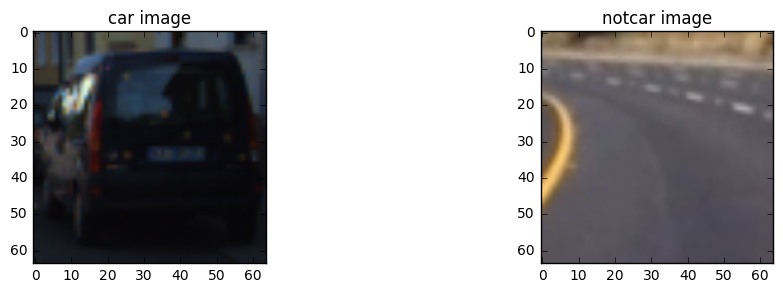

In [3]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

images = [car_image, notcar_image]
titles = ['car image', 'notcar image']

fig = plt.figure(figsize=(12, 3))
visualize(fig, 1, 2, images, titles)


In [4]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 100
random_idxs = np.random.randint(0, len(cars), n_samples)
#test_cars = np.array(cars)[random_idxs]
#test_notcars = np.array(notcars)[random_idxs]
test_cars = cars
test_notcars = notcars
car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:', orient, 'orientations,', pix_per_cell, 'pixels per cell,', cell_per_block, 'cells per block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time() - t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


615.0539679527283 Seconds to compute features...
Using: 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
18.95 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


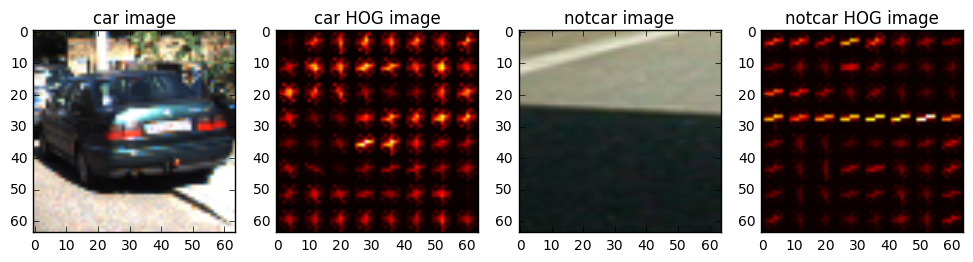

In [5]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12, 3))
visualize(fig, 1, 4, images, titles)


3.8053998947143555 seconds to process one image searching 100 windows
3.324191093444824 seconds to process one image searching 100 windows
3.1743643283843994 seconds to process one image searching 100 windows
3.173474073410034 seconds to process one image searching 100 windows
3.3104987144470215 seconds to process one image searching 100 windows
3.246474504470825 seconds to process one image searching 100 windows


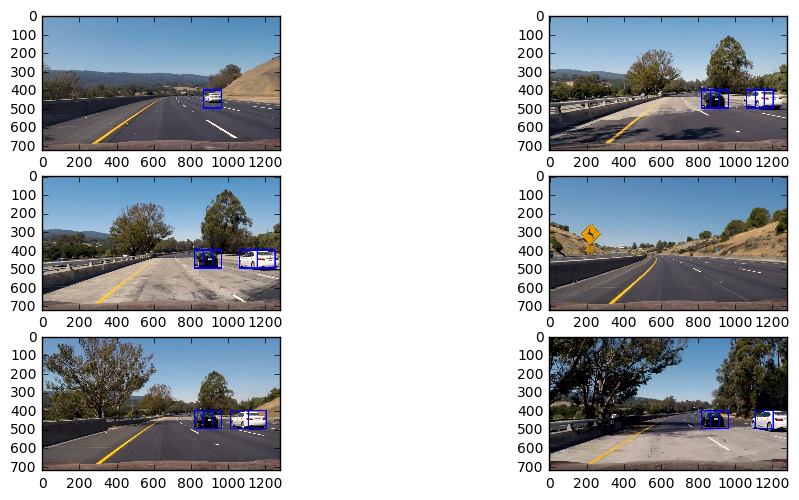

In [6]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5
for img_src in example_images:
  t1 = time.time()
  img = mpimg.imread(img_src)
  draw_img = np.copy(img)
  img = img.astype(np.float32)/255
#  print(np.min(img), np.max(img))

  windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(overlap, overlap))
  hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
  window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
  images.append(window_img)
  titles.append('')
  print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')

fig = plt.figure(figsize=(12, 10), dpi=300)
visualize(fig, 5, 2, images, titles)


/home/jun/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/jun/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/jun/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, 

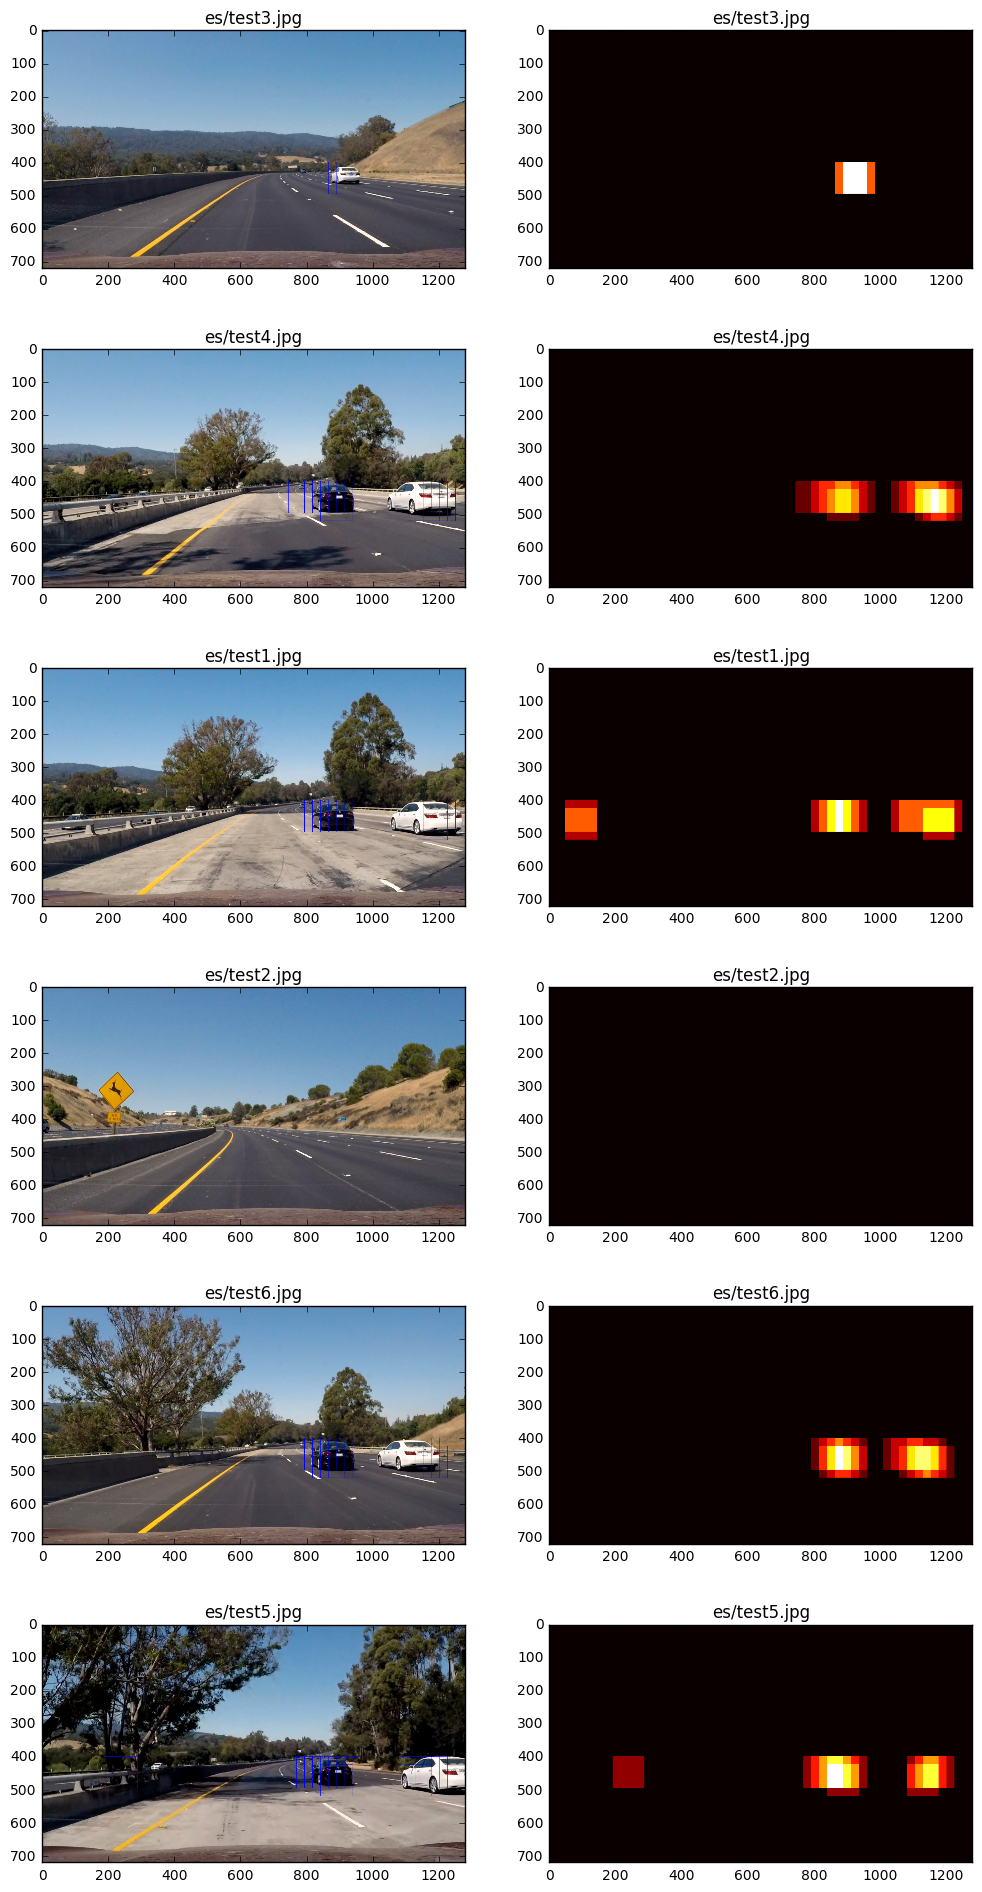

In [7]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
  draw_img = np.copy(img)
  heatmap = np.zeros_like(img[:,:,0])
  img = img.astype(np.float32)/255
  img_tosearch = img[ystart:ystop,:,:]
  ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
  if scale != 1:
    imshape = ctrans_tosearch.shape
    ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

  ch1 = ctrans_tosearch[:,:,0]
  ch2 = ctrans_tosearch[:,:,1]
  ch3 = ctrans_tosearch[:,:,2]

  nxblocks = (ch1.shape[1] // pix_per_cell) - 1
  nyblocks = (ch1.shape[0] // pix_per_cell) - 1
  nfeat_per_block = orient*cell_per_block**2
  
  window = 64
  nblocks_per_window = (window // pix_per_cell) - 1
  cells_per_step = 2
  nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
  nysteps = (nyblocks - nblocks_per_window) // cells_per_step

  # Compute individual channel HOG features for the entire image
  hog1 = get_hog_feature(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
  hog2 = get_hog_feature(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
  hog3 = get_hog_feature(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

  for xb in range(nxsteps):
    for yb in range(nysteps):
        ypos = yb*cells_per_step
        xpos = xb*cells_per_step

        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

        spatial_features = bin_spatial(subimg, size=spatial_size)
        hist_features = color_hist(subimg, nbins=hist_bins)

        test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)))
        test_prediction = svc.predict(test_features)

        if test_prediction == 1:
          xbox_left = np.int(xleft * scale)
          ytop_draw = np.int(ytop * scale)
          win_draw = np.int(window * scale)
          cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart), (0,0,255))
          heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
  return draw_img, heatmap

out_images = []
out_titles = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
  t = time.time()
  img = mpimg.imread(img_src)
  draw_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

  out_images.append(draw_img)
  out_images.append(heatmap)

  out_titles.append(img_src[-12:])
  out_titles.append(img_src[-12:])

fig = plt.figure(figsize=(12,24))
visualize(fig, len(out_images)/2, 2, out_images, out_titles)


In [8]:
from scipy.ndimage.measurements import label
        
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
  heatmap[heatmap <= threshold] = 0
  return heatmap

def draw_labeled_bboxes(img, labels):
  for car_number in range(1, labels[1]+1):
    nonzero = (labels[0] == car_number).nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
  return img


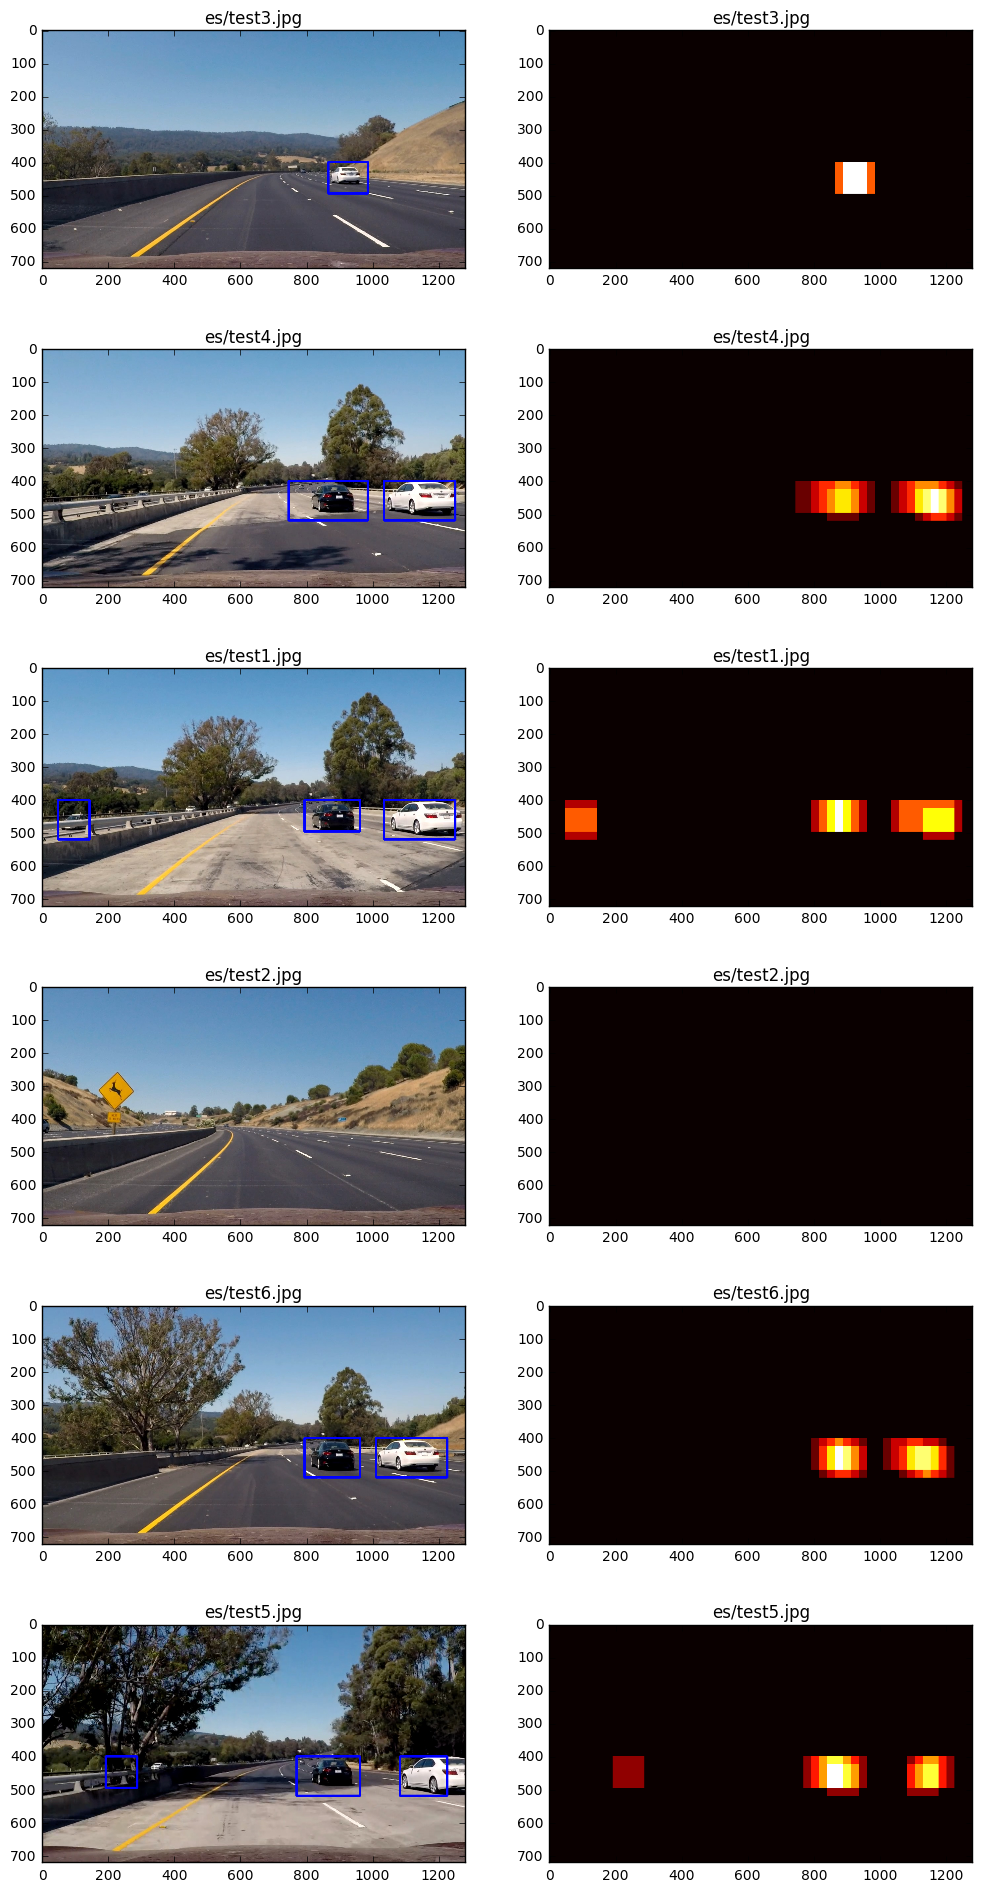

In [11]:
out_images = []
out_maps = []
scale = 1.5
for img_src in example_images:
  img = mpimg.imread(img_src)
  out_img, heat_map = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#  heat_map = apply_threshold(heat_map, 2)
  labels = label(heat_map)
  draw_img = draw_labeled_bboxes(np.copy(img), labels)
  out_images.append(draw_img)
  out_images.append(heat_map)

fig = plt.figure(figsize = (12, 24))
visualize(fig, len(out_images)/2, 2, out_images, out_titles)

def process_image(img):
  out_img, heat_map = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
  labels = label(heat_map)
  draw_img = draw_labeled_bboxes(np.copy(img), labels)
  return draw_img


In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'output.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)


[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [07:52<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 



In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))